## **Pendahuluan**

Pada praktikum ini, kita akan membangun sebuah model klasifikasi gambar menggunakan TensorFlow dan Keras.
Model ini akan digunakan untuk mengklasifikasikan gambar menjadi tiga kategori: **Rock, Paper, dan Scissors**.

Agar proses pelatihan menjadi lebih efisien dan cepat, kita akan memanfaatkan teknik **Transfer Learning** dengan menggunakan model pre-trained **MobileNetV2** sebagai feature extractor.

### **Dataset**

Dataset yang digunakan dalam praktikum ini berasal dari Kaggle, dan dapat diunduh melalui tautan berikut:

🔗 [Rock-Paper-Scissors Dataset – Kaggle](https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors)

Setelah mendownload dataset dan mengekstraknya, **praktikan diwajibkan** untuk menyusun struktur folder dataset menjadi seperti berikut:

<pre>
dataset/
    rock/
    paper/
    scissor/
</pre>



### **Load Dataset**
---

Kode di bawah ini digunakan untuk memuat dataset citra dari struktur folder yang telah disiapkan sebelumnya.

Praktikan diminta untuk:

- Menentukan **ukuran gambar** (`img_size`) sesuai dengan model yang akan digunakan (misalnya 224x224 untuk MobileNetV2).
- Mengatur **ukuran batch** (`batch_size`) sesuai kapasitas RAM/VRAM masing-masing.
- Mengisi nilai **`seed`** untuk memastikan bahwa hasil pembagian data bisa direproduksi kembali dengan urutan yang sama setiap kali dijalankan.

Dataset akan dibagi menjadi tiga bagian:
- **Training set**: 70%
- **Validation set**: 15%
- **Testing set**: 15%

Proses pemuatan data dilakukan dengan menggunakan fungsi bawaan TensorFlow, yaitu `image_dataset_from_directory()`, yang akan secara otomatis membaca gambar berdasarkan nama subfoldernya sebagai label.

> **Catatan:**
> Praktikan diperbolehkan untuk **menyesuaikan sendiri persentase pembagian data** (misalnya 80% train, 10% val, 10% test) selama proporsinya tetap konsisten dan masuk akal.  
> Praktikan juga dapat mengubah **ukuran gambar (`img_size`)** jika ingin menggunakan arsitektur model yang berbeda, serta **mengganti nilai `seed`** untuk mencoba hasil pembagian data yang berbeda.

Setelah training set dan validation+test set dimuat, validation dan test akan dipisahkan secara manual berdasarkan fraksi yang telah ditentukan.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import MobileNetV2
import os
import matplotlib.pyplot as plt
import numpy as np

# === PARAMETER YANG HARUS DITENTUKAN PRAKTIKAN ===
dataset_dir = "/content/drive/MyDrive/ML/Tugas 3/dataset"  # folder utama dataset
img_size = (224, 224)    # ukuran gambar untuk MobileNetV2
batch_size = 32          # ukuran batch
seed = 42                # random seed untuk reproducibility

# Dapatkan daftar kelas dari folder
classes = sorted(os.listdir(dataset_dir))
print(f"Kelas yang terdeteksi: {classes}")

# === ATURAN SPLIT DATA ===
train_frac = 0.70
val_frac = 0.15
test_frac = 0.15
vt_frac = val_frac + test_frac  # val + test (untuk split manual nanti)

print("\n=== MEMUAT DATASET ===")
print(f"Train: {train_frac*100}%, Validation: {val_frac*100}%, Test: {test_frac*100}%")

# === MEMUAT TRAIN DATASET ===
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=vt_frac,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",  # gunakan one-hot encoding
)

# === MEMUAT VALIDATION + TEST DATASET (gabungan) ===
val_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=vt_frac,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
)

# === SPLIT VAL DAN TEST SECARA MANUAL ===
vt_batches = tf.data.experimental.cardinality(val_test_ds).numpy()
val_batches = int(vt_batches * (val_frac / vt_frac))  # hitung proporsi val dalam val+test
val_ds = val_test_ds.take(val_batches)
test_ds = val_test_ds.skip(val_batches)

print(f"Jumlah batch - Train: {tf.data.experimental.cardinality(train_ds).numpy()}, "
      f"Validation: {tf.data.experimental.cardinality(val_ds).numpy()}, "
      f"Test: {tf.data.experimental.cardinality(test_ds).numpy()}")

Kelas yang terdeteksi: ['paper', 'rock', 'scissors']

=== MEMUAT DATASET ===
Train: 70.0%, Validation: 15.0%, Test: 15.0%
Found 2188 files belonging to 3 classes.
Using 1532 files for training.
Found 2188 files belonging to 3 classes.
Using 656 files for validation.
Jumlah batch - Train: 48, Validation: 10, Test: 11


### **Preprocessing dan Augmentasi Data**
---

Sebelum gambar dapat digunakan untuk melatih model, dataset perlu melalui proses **preprocessing** terlebih dahulu. Preprocessing ini bertujuan untuk memastikan bahwa semua input gambar berada dalam skala nilai yang konsisten dan sesuai dengan ekspektasi dari model.

Pada praktikum ini, preprocessing dilakukan melalui dua tahap:

1. **Normalisasi**:  
   Setiap pixel gambar yang awalnya berada pada rentang nilai **[0, 255]** diubah ke rentang **[0, 1]** dengan menggunakan layer `Rescaling(1./255)`.

2. **Augmentasi** (opsional):  
   Untuk meningkatkan variasi data dan mengurangi overfitting, dilakukan augmentasi pada **data training saja**. Augmentasi dilakukan melalui transformasi berikut:
   - `RandomFlip("horizontal")`: membalik gambar secara horizontal.
   - `RandomRotation(0.1)`: memutar gambar secara acak hingga 10%.
   - `RandomZoom(0.1, 0.1)`: melakukan zoom in/out hingga 10%.
   - `RandomContrast(0.1)`: mengubah kontras gambar secara acak hingga ±10%.

Semua preprocessing dan augmentasi dilakukan melalui fungsi `prep()`.  
Fungsi ini menerima parameter `augment` untuk menentukan apakah augmentasi akan diterapkan atau tidak.  
- Jika `augment=True`, maka data akan dinormalisasi lalu diaugmentasi.  
- Jika `augment=False`, maka hanya normalisasi yang dilakukan (untuk validation dan test set).

Setelah diproses, setiap dataset akan di-cache dan di-prefetch menggunakan `AUTOTUNE` untuk mengoptimalkan performa saat training.

> **Catatan untuk praktikan:**  
> Praktikan dapat menyesuaikan jenis dan tingkat augmentasi pada `aug_layer` untuk melihat pengaruhnya terhadap performa model. Namun, augmentasi **hanya boleh diterapkan pada training set**.


In [ ]:
# === PREPROCESSING DAN AUGMENTASI ===
# Normalisasi dan augmentasi
norm_layer = tf.keras.Sequential([
    layers.Rescaling(1./255),  # normalisasi ke [0,1]
])

aug_layer = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),       # flip kiri-kanan
    layers.RandomRotation(0.2),            # rotasi ±20%
    layers.RandomZoom(0.2, 0.2),           # zoom in/out sampai 20%
    layers.RandomContrast(0.2),            # kontras ±20%
    layers.RandomTranslation(0.1, 0.1),    # translasi hingga 10%
    layers.RandomBrightness(0.2),          # kecerahan ±20%
])

# Fungsi untuk mempersiapkan dataset
def prep(ds, augment=False):
    if augment:
        ds = ds.map(lambda x, y: (aug_layer(norm_layer(x), training=True), y),
                   num_parallel_calls=tf.data.AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (norm_layer(x), y),
                   num_parallel_calls=tf.data.AUTOTUNE)
    return ds.cache().prefetch(tf.data.AUTOTUNE)

# Aktifkan augmentasi hanya untuk training set
train_ds = prep(train_ds, augment=True)   # Augmentasi untuk training
val_ds = prep(val_ds, augment=False)      # Tanpa augmentasi untuk validasi
test_ds = prep(test_ds, augment=False)    # Tanpa augmentasi untuk testing


### **Build Model dan Training**
---

Pada tahap ini, kita akan membangun arsitektur model menggunakan teknik **Transfer Learning** dengan memanfaatkan **MobileNetV2** sebagai feature extractor.

Praktikan diminta untuk:

- **Melengkapi input layer** (`inputs`) dengan ukuran shape gambar yang sesuai.
- **Melengkapi output layer** (`outputs`) dengan jumlah neuron yang sama dengan jumlah kelas target (jumlah kategori pada dataset).

Bagian head klasifikasi model disusun dengan struktur:

- **GlobalAveragePooling2D**: Mengubah output feature map menjadi satu vektor rata-rata per channel.
- **Dropout**: Teknik regularisasi untuk mengurangi overfitting.
- **Dense (Softmax)**: Layer output yang mengklasifikasikan input ke dalam salah satu kelas.

---

### **Training Model**

Sebelum memulai proses pelatihan, kita juga telah mendefinisikan dua buah callbacks:

- `EarlyStopping`: Untuk menghentikan pelatihan jika validation loss tidak membaik setelah sejumlah epoch tertentu.
- `ModelCheckpoint`: Untuk menyimpan model terbaik berdasarkan validation loss.

Praktikan diminta untuk:

- **Melengkapi list callbacks** di fungsi `model.fit()`, dengan menambahkan kedua callbacks yang telah dibuat sebelumnya (`early_stopping` dan `model_checkpoint`).
- Menjalankan training selama **50 epoch** atau hingga proses berhenti otomatis karena `EarlyStopping`.

> **Catatan:**  
> Dengan menggunakan callbacks, kita dapat menghindari overfitting dan memastikan model terbaik tersimpan otomatis.



In [ ]:
print("\n=== MEMBUAT MODEL ===")

# Load pre-trained base
base_model = MobileNetV2(
    input_shape=(*img_size, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # Bekukan layer MobileNetV2

# Tampilkan informasi base model
print(f"Base model: MobileNetV2")
print(f"Input shape: {img_size + (3,)}")
print(f"Output shape dari base model: {base_model.output_shape}")
print(f"Jumlah layer: {len(base_model.layers)}")

# Tambahkan head klasifikasi baru
inputs = tf.keras.Input(shape=(*img_size, 3))  # Input shape sesuai img_size + channel RGB
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(classes), activation="softmax")(x)  # Output sesuai jumlah kelas

model = models.Model(inputs, outputs)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Tampilkan ringkasan model
model.summary()

# Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True
)

model_checkpoint = callbacks.ModelCheckpoint(
    "best_transfer.h5",
    monitor="val_accuracy",
    save_best_only=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

print("\n=== MULAI TRAINING ===")

# Training model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)


=== MEMBUAT MODEL ===
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Base model: MobileNetV2
Input shape: (224, 224, 3)
Output shape dari base model: (None, 7, 7, 1280)
Jumlah layer: 154


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,051,075 (11.64 MB)

 Trainable params: 790,531 (3.02 MB)

 Non-trainable params: 2,260,544 (8.62 MB)


=== MULAI TRAINING ===
Epoch 1/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3467 - loss: 1.9609

48/48 ━━━━━━━━━━━━━━━━━━━━ 592s 12s/step - accuracy: 0.3469 - loss: 1.9577 - val_accuracy: 0.7719 - val_loss: 0.7637 - learning_rate: 0.0010
Epoch 2/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.3971 - loss: 1.3591 - val_accuracy: 0.6719 - val_loss: 0.7061 - learning_rate: 0.0010
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.3805 - loss: 1.2306 - val_accuracy: 0.3531 - val_loss: 1.5805 - learning_rate: 0.0010
Epoch 4/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.4436 - loss: 1.1407 - val_accuracy: 0.6844 - val_loss: 0.7345 - learning_rate: 0.0010
Epoch 5/30
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4194 - loss: 1.0938

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.4202 - loss: 1.0928 - val_accuracy: 0.8719 - val_loss: 0.3882 - learning_rate: 0.0010
Epoch 6/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4550 - loss: 1.0454 - val_accuracy: 0.8313 - val_loss: 0.3606 - learning_rate: 0.0010
Epoch 7/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4698 - loss: 1.0028 - val_accuracy: 0.8125 - val_loss: 0.4456 - learning_rate: 0.0010
Epoch 8/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.4857 - loss: 0.9688 - val_accuracy: 0.8625 - val_loss: 0.3097 - learning_rate: 0.0010
Epoch 9/30
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5104 - loss: 0.9498

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5105 - loss: 0.9490 - val_accuracy: 0.9031 - val_loss: 0.2259 - learning_rate: 0.0010
Epoch 10/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.4799 - loss: 0.9321 - val_accuracy: 0.8656 - val_loss: 0.2916 - learning_rate: 0.0010
Epoch 11/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5247 - loss: 0.8989 - val_accuracy: 0.8969 - val_loss: 0.2494 - learning_rate: 0.0010
Epoch 12/30
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5136 - loss: 0.9179
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5140 - loss: 0.9171 - val_accuracy: 0.8781 - val_loss: 0.3235 - learning_rate: 0.0010
Epoch 13/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5304 - loss: 0.8979 - val_accuracy: 0.8687 - val_loss: 0.3232 - learning_rate: 5.0000e-04
Epoch 14/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5580 - loss: 0.8315 - val_accur

### **Evaluasi Model**
---

Setelah model selesai dilatih, langkah berikutnya adalah mengevaluasi performanya pada **test set**.

Evaluasi dilakukan menggunakan dua pendekatan utama:

1. **Classification Report**  
   Menampilkan metrik klasifikasi seperti:
   - **Precision**: Seberapa akurat model saat membuat prediksi positif.
   - **Recall**: Seberapa baik model menangkap semua sampel positif.
   - **F1-Score**: Harmoni antara precision dan recall.
   - **Accuracy**: Persentase prediksi yang benar dari semua prediksi.

2. **Confusion Matrix**  
   Menunjukkan jumlah prediksi benar dan salah untuk masing-masing kelas, dalam bentuk tabel.  
   Dengan confusion matrix, kita bisa melihat pola kesalahan model (misal, apakah model sering salah membedakan "rock" dengan "paper", dll).

---

#### Langkah-langkah yang dilakukan pada kode:

- Menggunakan model untuk melakukan prediksi pada seluruh test dataset.
- Membandingkan hasil prediksi dengan label asli.
- Menampilkan classification report menggunakan `classification_report` dari scikit-learn.
- Menghitung dan memvisualisasikan confusion matrix menggunakan `ConfusionMatrixDisplay`.

> **Catatan untuk praktikan:**  
> Perhatikan nilai **precision**, **recall**, dan **f1-score** dari masing-masing kelas.  
> Jika terdapat ketidakseimbangan performa antar kelas, analisis kemungkinan penyebabnya (misalnya karena jumlah data tidak seimbang, kesamaan visual antar kelas, dsb).



=== EVALUASI MODEL ===
11/11 ━━━━━━━━━━━━━━━━━━━━ 97s 7s/step - accuracy: 0.8990 - loss: 0.2339
Test accuracy: 0.8869
Test loss: 0.2686


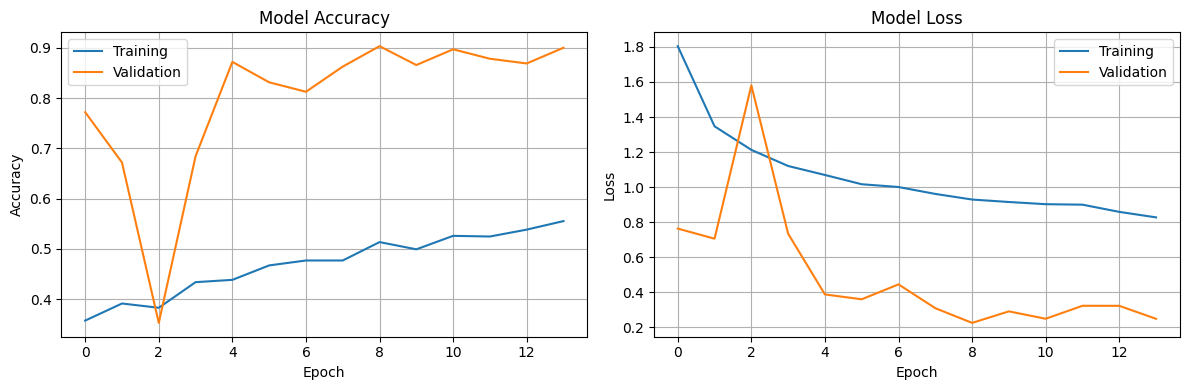


=== FINE-TUNING MODEL ===
Memulai fine-tuning...
Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.3942 - loss: 1.1268

48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 255ms/step - accuracy: 0.3950 - loss: 1.1252 - val_accuracy: 0.9125 - val_loss: 0.2119 - learning_rate: 1.0000e-04
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5042 - loss: 0.9314 - val_accuracy: 0.8938 - val_loss: 0.2638 - learning_rate: 1.0000e-04
Epoch 3/20
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5329 - loss: 0.8696
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5334 - loss: 0.8685 - val_accuracy: 0.8969 - val_loss: 0.2636 - learning_rate: 1.0000e-04
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5907 - loss: 0.7717 - val_accuracy: 0.8750 - val_loss: 0.3029 - learning_rate: 2.0000e-05
Epoch 5/20
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6151 - loss: 0.7216
Epoch 5: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.6151 - loss: 0.7211 - v

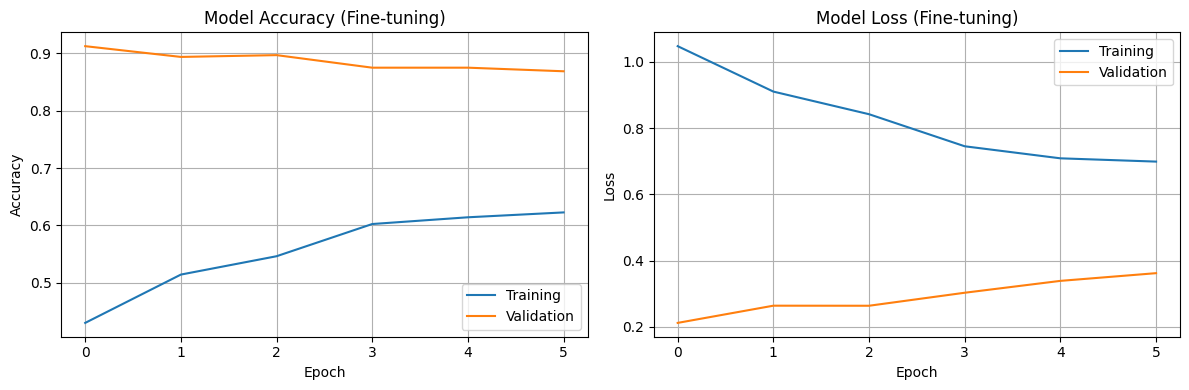


Model terbaik disimpan sebagai 'best_fine_tuned.h5'

=== CONTOH PREDIKSI ===


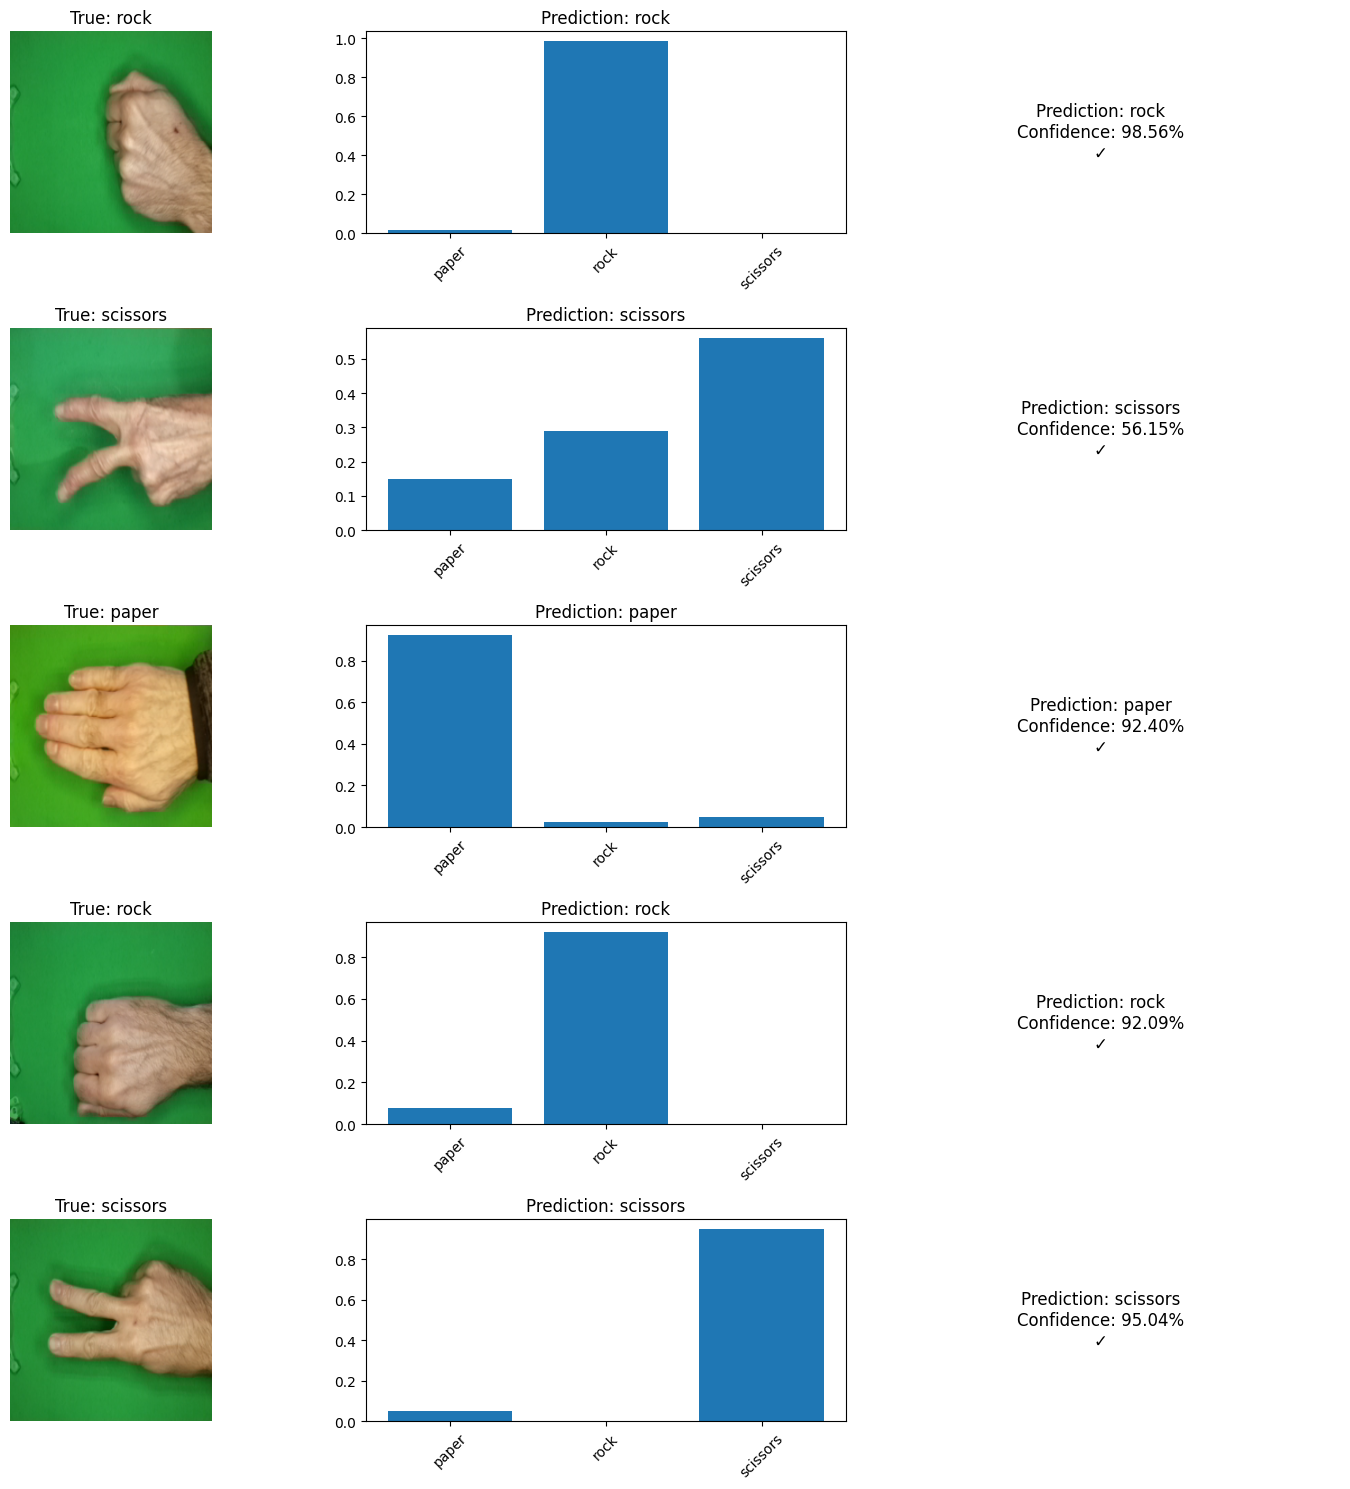

Model akhir disimpan sebagai 'final_model.h5'


In [ ]:
# Evaluasi model pada test set
print("\n=== EVALUASI MODEL ===")
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Plot history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

print("\n=== FINE-TUNING MODEL ===")
# Sekarang kita lakukan fine-tuning beberapa layer teratas dari MobileNetV2
base_model.trainable = True

# Bekukan sebagian besar layer dasar, dan hanya latih beberapa layer terakhir
for layer in base_model.layers[:-20]:  # Bekukan semua kecuali 20 layer terakhir
    layer.trainable = False

# Compile model dengan learning rate yang lebih kecil untuk fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Learning rate lebih kecil
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("Memulai fine-tuning...")
# Fine-tuning
fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
        callbacks.ModelCheckpoint("best_fine_tuned.h5", monitor="val_accuracy", save_best_only=True),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
    ]
)

# Evaluasi model fine-tuned pada test set
print("\n=== EVALUASI MODEL FINE-TUNED ===")
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy setelah fine-tuning: {test_acc:.4f}")
print(f"Test loss setelah fine-tuning: {test_loss:.4f}")

# Plot history fine-tuning
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(fine_tune_history.history['accuracy'], label='Training')
plt.plot(fine_tune_history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy (Fine-tuning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(fine_tune_history.history['loss'], label='Training')
plt.plot(fine_tune_history.history['val_loss'], label='Validation')
plt.title('Model Loss (Fine-tuning)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('fine_tuning_history.png')
plt.show()

print("\nModel terbaik disimpan sebagai 'best_fine_tuned.h5'")

# Test model dengan beberapa gambar contoh
def test_predict_images(model, dataset, num_images=5):
    """Prediksi beberapa gambar dari dataset untuk visual inspection"""
    plt.figure(figsize=(15, 3*num_images))
    images_shown = 0

    for images, labels in dataset:
        for i in range(min(len(images), num_images - images_shown)):
            pred = model.predict(tf.expand_dims(images[i], 0), verbose=0)
            pred_class = np.argmax(pred[0])
            true_class = np.argmax(labels[i])

            plt.subplot(num_images, 3, images_shown*3 + 1)
            plt.imshow(images[i]/1.0)  # Normalisasi untuk tampilan
            plt.title(f"True: {classes[true_class]}")
            plt.axis('off')

            plt.subplot(num_images, 3, images_shown*3 + 2)
            plt.bar(range(len(classes)), pred[0])
            plt.xticks(range(len(classes)), classes, rotation=45)
            plt.title(f"Prediction: {classes[pred_class]}")

            plt.subplot(num_images, 3, images_shown*3 + 3)
            correct = "✓" if pred_class == true_class else "✗"
            confidence = pred[0][pred_class] * 100
            plt.text(0.5, 0.5, f"Prediction: {classes[pred_class]}\nConfidence: {confidence:.2f}%\n{correct}",
                    horizontalalignment='center', verticalalignment='center', fontsize=12)
            plt.axis('off')

            images_shown += 1
            if images_shown >= num_images:
                break
        if images_shown >= num_images:
            break

    plt.tight_layout()
    plt.savefig('test_predictions.png')
    plt.show()

print("\n=== CONTOH PREDIKSI ===")
test_predict_images(model, test_ds, num_images=5)

# Simpan model terakhir
model.save("final_model.h5")
print("Model akhir disimpan sebagai 'final_model.h5'")

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 317ms/step
=== Classification Report ===
              precision    recall  f1-score   support

       paper     0.8684    0.7586    0.8098        87
        rock     0.9919    0.9919    0.9919       124
    scissors     0.8456    0.9200    0.8812       125

    accuracy                         0.9048       336
   macro avg     0.9020    0.8902    0.8943       336
weighted avg     0.9055    0.9048    0.9036       336



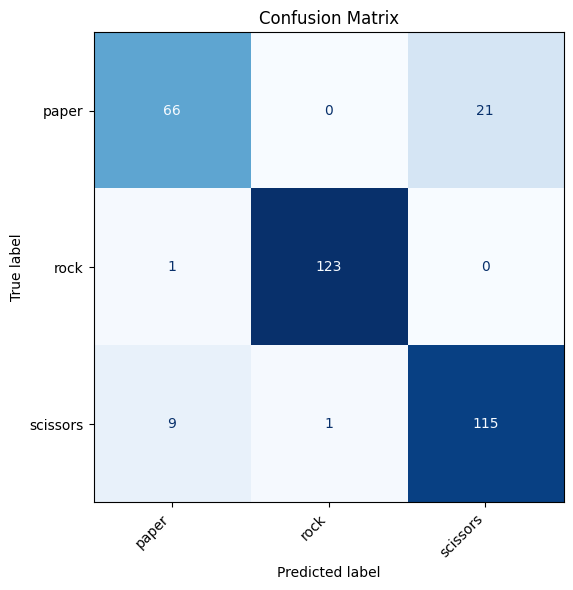

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# dapatkan prediksi probabilitas dan label dari test set
y_pred_probs = model.predict(test_ds)               # shape = (N, num_classes)
y_pred = np.argmax(y_pred_probs, axis=1)             # ambil indeks prediksi tertinggi (shape: (N,))

# ekstrak label asli dari test_ds
#    Karena test_ds bertipe (x_batch, y_batch) dengan label one-hot, kita ambil argmax dari y_batch
y_true = np.concatenate([
    np.argmax(y.numpy(), axis=1)
    for _, y in test_ds
], axis=0)

# tampilkan classification report
print("=== Classification Report ===")
print(classification_report(
    y_true,
    y_pred,
    target_names=classes,
    digits=4
))

# hitung dan tampilkan confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Setelah proses pelatihan selesai, model yang telah dilatih akan secara otomatis disimpan oleh callback `ModelCheckpoint` ke dalam file `.h5`.

Model ini dapat langsung digunakan dalam pengembangan aplikasi backend yang menggunakan **FastAPI** atau frontend berbasis **Streamlit**, untuk membuat aplikasi klasifikasi gambar.